# This notebook extracts each cell of tables in PNG files within a folder 

In [ ]:
import os
def get_file_path_list(path):  
    full_path_list = []
    for path, subdirs, files in os.walk(path):
        for filename in files:
            f = os.path.join(path, filename)
            full_path_list.append(f)
    return full_path_list

In [266]:
import zipfile
with zipfile.ZipFile('img_from_pdf.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [80]:
!rm -rf saved-images/
!rm -rf saved-images.zip

# Ingest one image

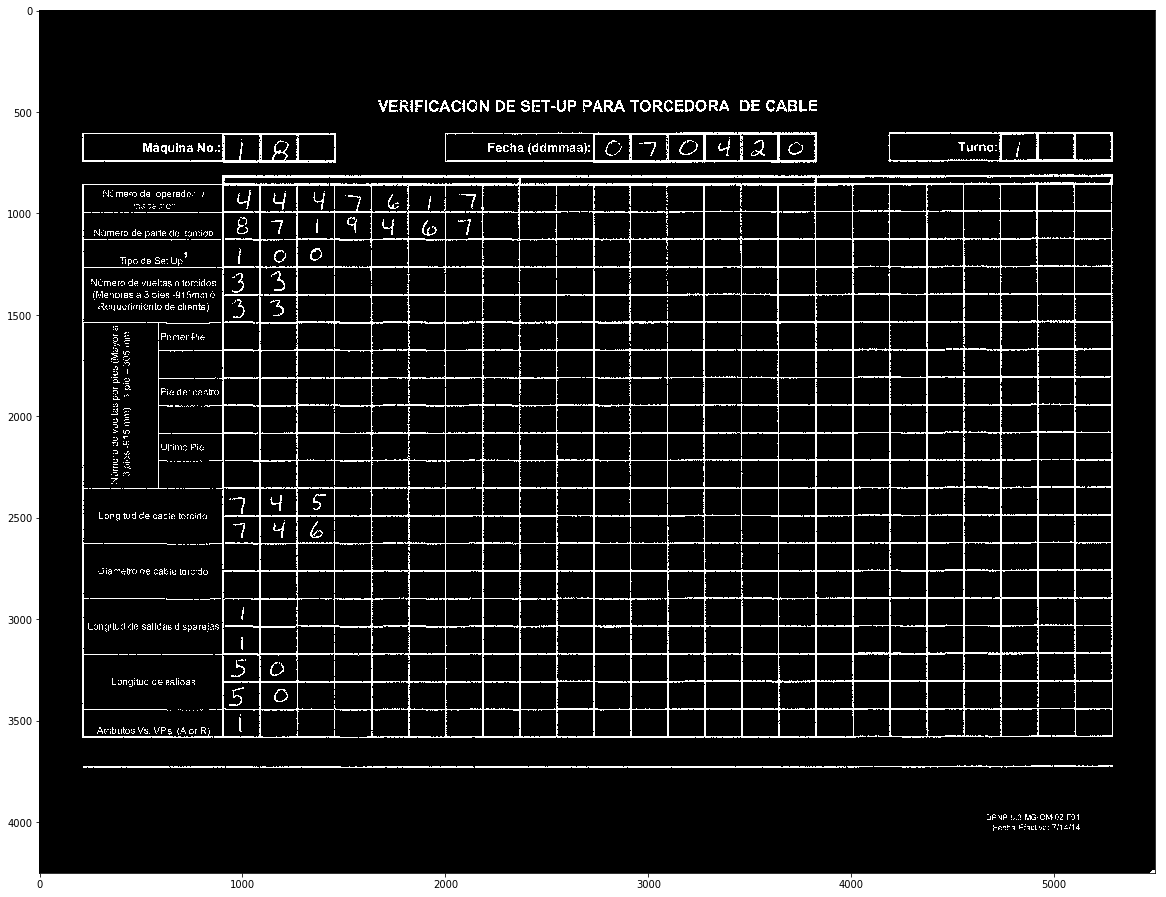

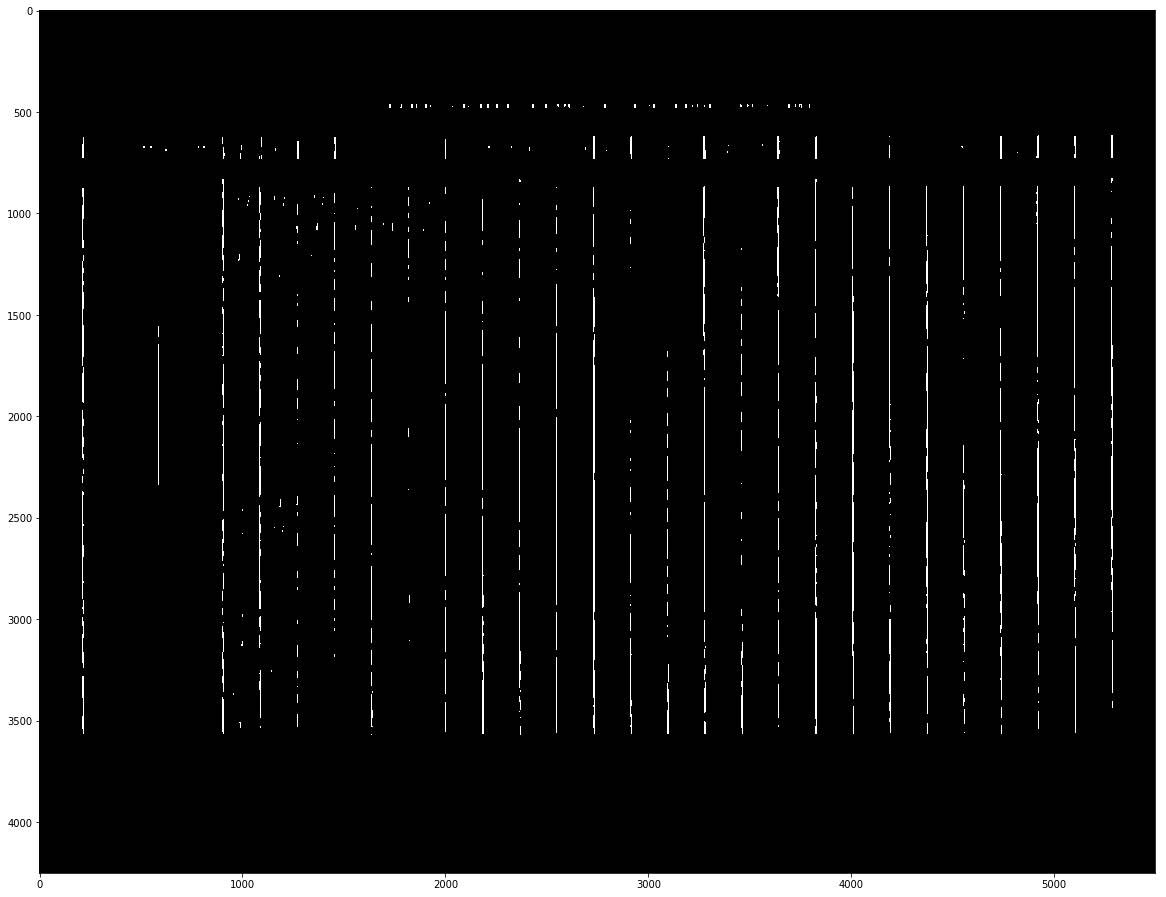

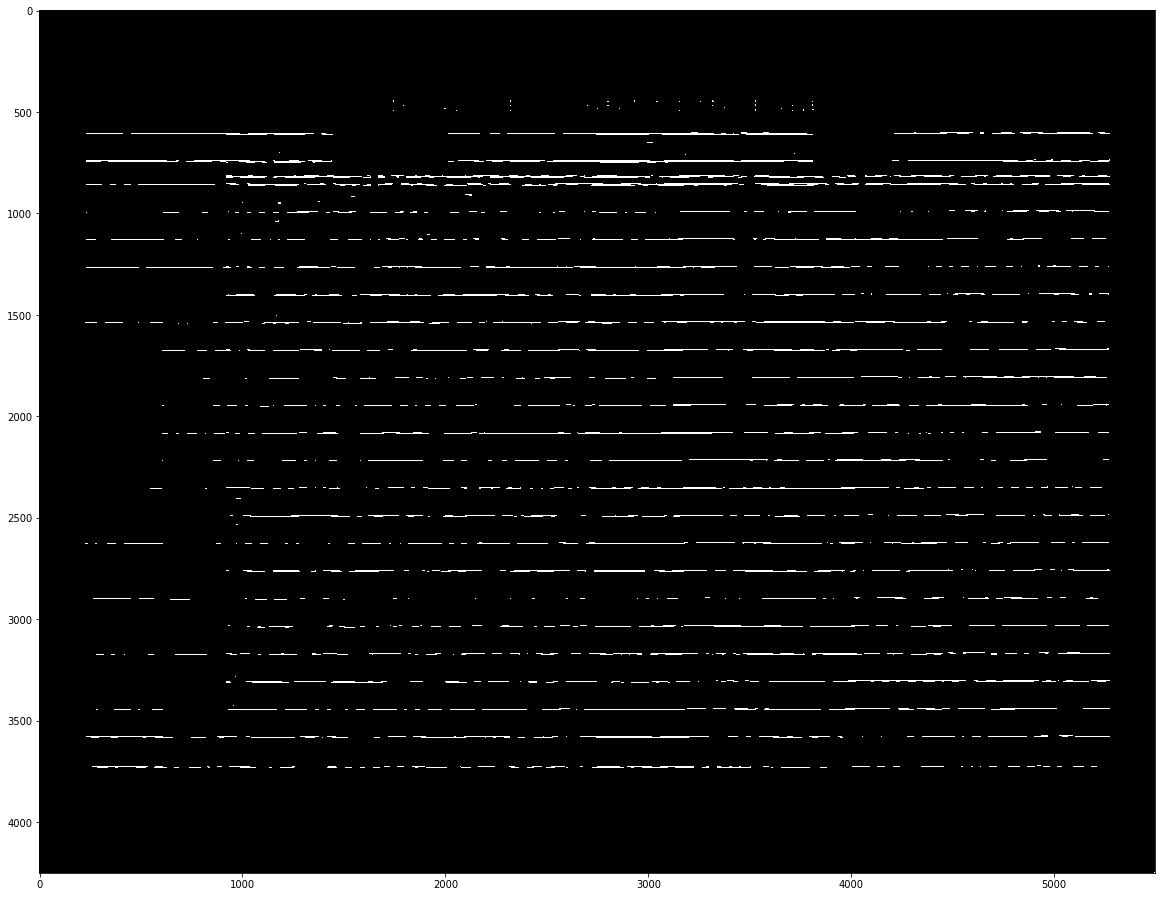

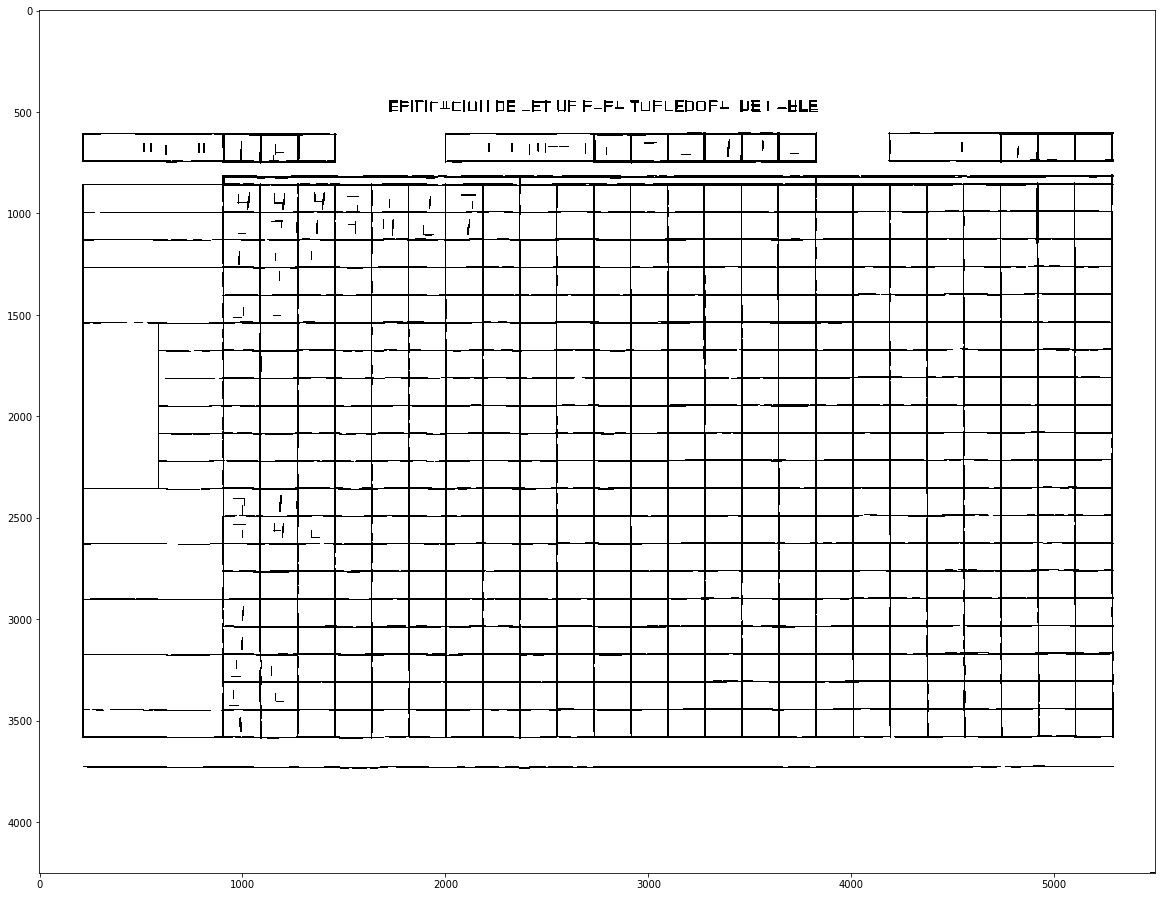

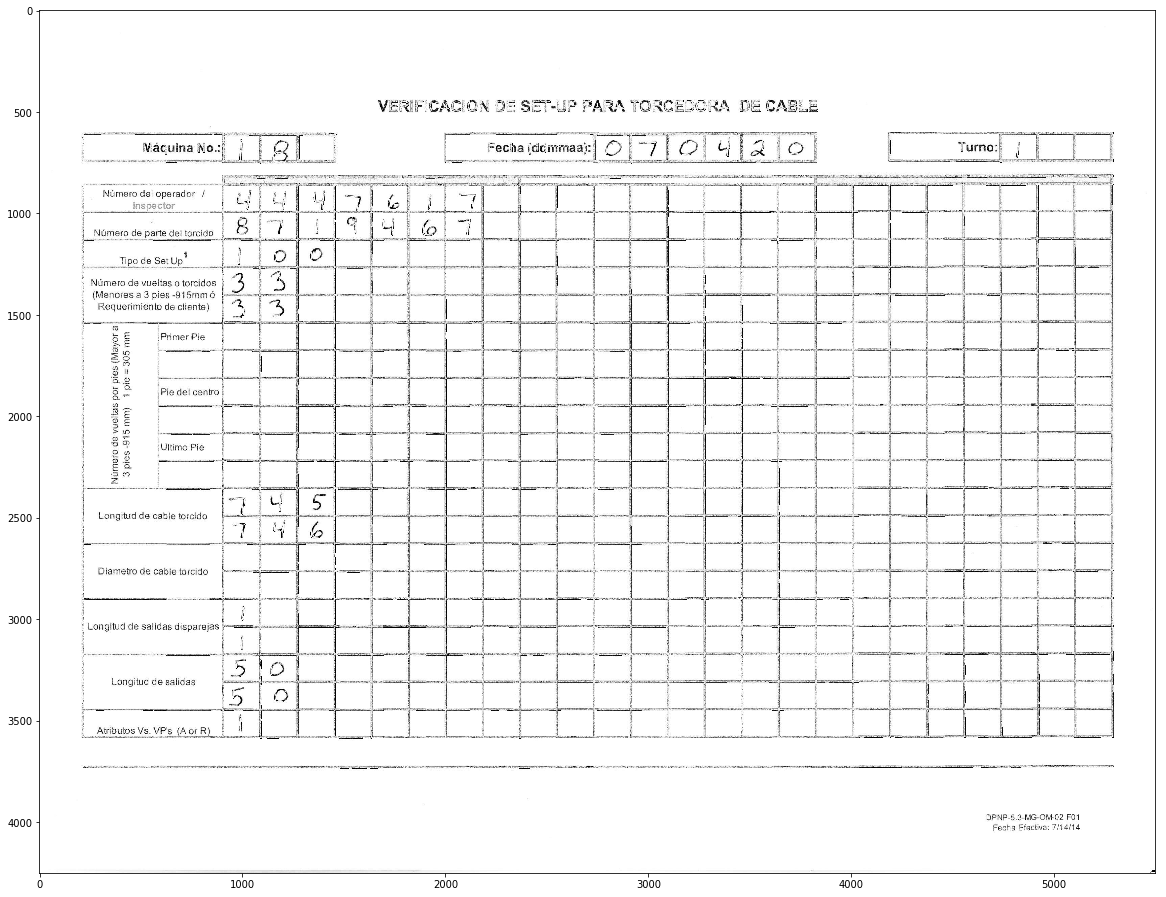

    0     1   2     3     4     5   6   7   8   9   ...  14  15  16  17  18  \
0    1   1 1                                        ...   1   1               
1    1     1   1   1 1     1     1   1              ...                       
2    1   1 1   1     1     1   1 1   1              ...                       
3    1     1   1                                    ...                       
4    1     1                                        ...                       
5          1                                        ...                       
6    1     1                                        ...                       
7                                                   ...                       
8                                                   ...                       
9                                                   ...                       
10                                                  ...                       
11                                                  

In [314]:
!rm -rf saved-images/
!mkdir saved-images

crop_factor = .1

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from pylab import rcParams

%matplotlib inline
try:
    from PIL import Image
except ImportError:
    import Image
# import pytesseract

#read your file
file=r'3.png'
file=r'img_from_pdf/3-100.png'
file='img_from_pdf/2-103.png'
file=r'kevin_test.png'
file = '../4-0.png'
# file=r'image_form.png'

img = cv2.imread(file,0)
img.shape

#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('cv_inverted.png',img_bin)
#Plotting the image to see the output
rcParams['figure.figsize'] = 20, 20

plotting = plt.imshow(img_bin,cmap='gray')
plt.show()


############################################################################################################
#countcol(width) of kernel as 100th of total width
# # kernel_len = np.array(img).shape[1]//100
# kernel_len = np.array(img).shape[1]//100

# # Defining a vertical kernel to detect all vertical lines of image 
# ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# # Defining a horizontal kernel to detect all horizontal lines of image
# hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# # A kernel of 2x2
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))


# kernel_len = np.array(img).shape[1]//100
kernel_len = np.array(img).shape[1]//400

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

############################################################################################################
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("vertical.jpg",vertical_lines)
#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("horizontal.jpg",horizontal_lines)
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

plotting = plt.imshow(img_vh,cmap='gray')
plt.show()

#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

# Detect contours for following box detection
# contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

_, contours, _= cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
#     if (w<1000 and h<500):
#     print(w)
########################################################################
#####################   updated needed     #############################
########################################################################
#     if (w<75 and h<55 and w/h< 2 and w/h> 1):
    if (w < 400 and w/h< 2 and w/h> 1):
#         print(w)
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
########################################################################
########################################################################
########################################################################        
# plotting = plt.imshow(image,cmap='gray')
# plt.show()

#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
            
# print(column)
# print(row)

#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the center of each column

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()
# print(center)
#Regarding the distance to the columns center, the boxes are arranged in respective order

finalboxes = []
for i in range(1,len(row)): #000000000000    range(len(row))   00000000000000000000000000000000000000000000000000000000000000000000000000
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)


#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
pic = 0
meanvals = []
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dim = (64, 64)
                resizing = cv2.resize(resizing, dim, interpolation = cv2.INTER_AREA)
                s0 = resizing.shape[0]
                s1 = resizing.shape[1]
                resizing = resizing[int(s0*crop_factor):int(s0*(1-crop_factor)), int(s1*crop_factor):int(s1*(1-crop_factor))]
                if resizing.mean() < 253:
                    cv2.imwrite('saved-images/'+str(pic)+".png",resizing)
#                     print(resizing.mean())
                    meanvals.append(resizing.mean())
                    pic +=1   
                    out = '1'
                else:
                    out = ''
#                 resizing = resizing[y:y+5, x:x+5]

#                 dilation = cv2.dilate(resizing, kernel,iterations=1)
#                 erosion = cv2.erode(dilation, kernel,iterations=2)
             
                if(len(out)==0):
                    out = ' '
                inner = inner +" "+ out
            outer.append(inner)

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row)-1, countcol)) #0000000000  len(row)   0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel("output.xlsx")

# Loop over all images and save results in separate folders

In [300]:
!rm -rf crop_from_pdf/
os.mkdir('crop_from_pdf')
pic = 0
# def train_pics(file):
files = get_file_path_list('img_from_pdf')

for file in files: 
    print('crop_from_pdf/'+ file.split('/')[-1].split('-')[0])
    if not os.path.isdir('crop_from_pdf/'+ file.split('/')[-1].split('-')[0]):
        os.mkdir('crop_from_pdf/'+ file.split('/')[-1].split('-')[0])
        

    crop_factor = .1
    #read your file
    # file=r'image_form.png'

    img = cv2.imread(file,0)
    img.shape

    #thresholding the image to a binary image
    thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #inverting the image 
    img_bin = 255-img_bin

    kernel_len = np.array(img).shape[1]//200

    # Defining a vertical kernel to detect all vertical lines of image 
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

    ############################################################################################################
    #Use vertical kernel to detect and save the vertical lines in a jpg
    image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

    #Use horizontal kernel to detect and save the horizontal lines in a jpg
    image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

    # Combine horizontal and vertical lines in a new third image, with both having same weight.
    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)
    thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    bitxor = cv2.bitwise_xor(img,img_vh)
    bitnot = cv2.bitwise_not(bitxor)

    _, contours, _= cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
        # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)

    # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

    #Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

    #Get mean of heights
    mean = np.mean(heights)

    #Create list box to store all boxes in  
    box = []
    # Get position (x,y), width and height for every contour and show the contour on image
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
    #     if (w<1000 and h<500):

    ########################################################################
    #####################   updated needed     #############################
    ########################################################################
#         if (w<75 and h<55 and w/h< 2 and w/h> 1):
        if (w < 400 and w/h< 2 and w/h> 1):
            image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            box.append([x,y,w,h])
    ########################################################################
    ########################################################################
    ########################################################################        
    # plotting = plt.imshow(image,cmap='gray')
    # plt.show()

    #Creating two lists to define row and column in which cell is located
    row=[]
    column=[]
    j=0
#     print(box)

    #Sorting the boxes to their respective row and column
    for i in range(1,len(box)):    

        if(i==0):
            column.append(box[i])
            previous=box[i]    

        else:
            if(box[i][1]<=previous[1]+mean/2):
                column.append(box[i])
                previous=box[i]            

                if(i==len(box)-1):
                    row.append(column)        

            else:
                row.append(column)
                column=[]
                previous = box[i]
                column.append(box[i])

    # print(column)
    # print(row)

    #calculating maximum number of cells
    countcol = 0
    for i in range(len(row)):
        countcol = len(row[i])
        if countcol > countcol:
            countcol = countcol

    #Retrieving the center of each column
#     i = len(row)
    center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

    center=np.array(center)
    center.sort()
    # print(center)
    #Regarding the distance to the columns center, the boxes are arranged in respective order

    finalboxes = []
    for i in range(len(row)):
        lis=[]
        for k in range(countcol):
            lis.append([])
        for j in range(len(row[i])):
            diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
            minimum = min(diff)
            indexing = list(diff).index(minimum)
            lis[indexing].append(row[i][j])
        finalboxes.append(lis)


    #from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
    outer=[]
    meanvals = []
    for i in range(len(finalboxes)):
        for j in range(len(finalboxes[i])):
            inner=''
            if(len(finalboxes[i][j])==0):
                outer.append(' ')
            else:
                for k in range(len(finalboxes[i][j])):
                    y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                    finalimg = bitnot[x:x+h, y:y+w]
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dim = (64, 64)
                    resizing = cv2.resize(resizing, dim, interpolation = cv2.INTER_AREA)
                    s0 = resizing.shape[0]
                    s1 = resizing.shape[1]
                    resizing = resizing[int(s0*crop_factor):int(s0*(1-crop_factor)), int(s1*crop_factor):int(s1*(1-crop_factor))]
                    if resizing.mean() < 253:
                        name = file.split('/')[-1].split('-')[0]
                        name = 'crop_from_pdf/'+name+'/'+name+'-'+str(pic)+".png"
                        
                        cv2.imwrite(name,resizing)
                        pic +=1   


crop_from_pdf/8
crop_from_pdf/2
crop_from_pdf/9
crop_from_pdf/3
crop_from_pdf/5
crop_from_pdf/6
crop_from_pdf/5
crop_from_pdf/4
crop_from_pdf/6
crop_from_pdf/7
crop_from_pdf/7
crop_from_pdf/6
crop_from_pdf/7
crop_from_pdf/5
crop_from_pdf/5
crop_from_pdf/8
crop_from_pdf/8
crop_from_pdf/0
crop_from_pdf/4
crop_from_pdf/0
crop_from_pdf/0
crop_from_pdf/2
crop_from_pdf/1
crop_from_pdf/1
crop_from_pdf/5
crop_from_pdf/9
crop_from_pdf/5
crop_from_pdf/2
crop_from_pdf/9
crop_from_pdf/0
crop_from_pdf/6
crop_from_pdf/1
crop_from_pdf/6
crop_from_pdf/7
crop_from_pdf/1
crop_from_pdf/0
crop_from_pdf/3
crop_from_pdf/9
crop_from_pdf/1
crop_from_pdf/2
crop_from_pdf/8
crop_from_pdf/4
crop_from_pdf/3
crop_from_pdf/4
crop_from_pdf/7
crop_from_pdf/4
crop_from_pdf/0
crop_from_pdf/3
crop_from_pdf/3
crop_from_pdf/8
crop_from_pdf/2
crop_from_pdf/9


# Zip the created folder

In [303]:
import shutil
shutil.make_archive('crop_from_pdf', 'zip', 'crop_from_pdf')

'/home/ec2-user/SageMaker/Extract-Cells/crop_from_pdf.zip'